### Imports

In [1]:
# Dependencies
# pip install gym_super_mario_bros==7.3.0 nes_py
# pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
# pip install stable-baselines3[extra]
# pip install matplotlib
#####################################################
# Import game
import gym_super_mario_bros
# Joypad Wrapper
from nes_py.wrappers import JoypadSpace
# Simplified controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

### Setup Game

In [2]:
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [5]:
done = True
# Loop through each frame in the game
for step in range(1000):
    if done:
        env.reset()
    state, reward, done, info = env.step(env.action_space.sample())
    env.render()
env.close()

### Setup Environment

In [6]:
# Frame Stacker Wrapper & GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation
# Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv

from matplotlib import pyplot as plt

d:\Proggen\VirtualEnvironments\Anaconda\rl_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Base environment
env = gym_super_mario_bros.make('SuperMarioBros-v0')
# Simplify Controls
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# Grayscale
env = GrayScaleObservation(env, keep_dim=True)
# Wrap inside Dummy Environment
env = DummyVecEnv([lambda: env])
# Stack Frames
env= VecFrameStack(env, 4, channels_order='last')

##### Visualize Stacks

In [8]:
state = env.reset()

In [11]:
state, reward, done, info = env.step([env.action_space.sample()])

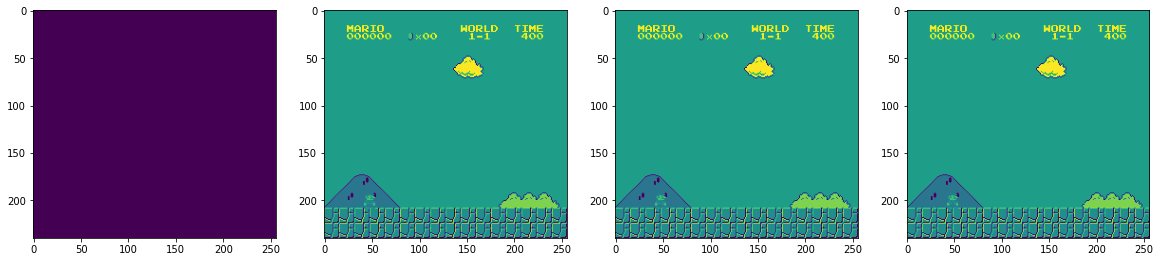

In [13]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

## Train RL Model

In [8]:
import os
# PPO algorithmus
from stable_baselines3 import PPO
# Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [9]:
# Callback to save our models
class TrainAndLoggingCallback(BaseCallback):
    # check_freq = after how many steps shall save model
    # save_path = path to save
    def __init__ (self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
    
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'superMario_Version_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

##### Setup saving the model

In [10]:
CHECKPOINT_DIR = './Training/Saved_Models'
LOG_DIR = './Training/Logs'

saveModel = TrainAndLoggingCallback(check_freq=100000, save_path=CHECKPOINT_DIR)

##### Train Model

In [11]:
# verbose = 1 -> getting lot of information
# learning rate -> the higher the faster but less good
# n_step -> how many frames the model uses until updates model
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, n_steps=512)

Using cuda device
Wrapping the env in a VecTransposeImage.


In [12]:
# training our model
# total_timesteps -> how many frames (in our case moves) the system trains on 
model.learn(total_timesteps=1000000, callback=saveModel)

Logging to ./Training/Logs\PPO_2


d:\Proggen\VirtualEnvironments\Anaconda\rl_env\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


----------------------------
| time/              |     |
|    fps             | 54  |
|    iterations      | 1   |
|    time_elapsed    | 9   |
|    total_timesteps | 512 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 43            |
|    iterations           | 2             |
|    time_elapsed         | 23            |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 1.2185541e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | 0.00217       |
|    learning_rate        | 1e-06         |
|    loss                 | 188           |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000126     |
|    value_loss           | 431           |
-------------------------------------------
-----

### Test it out

In [14]:
# Load Model
model = PPO.load('./Training/Saved_Models/superMario_Version_1000000')

In [ ]:
state = env.reset()

# Loop game
while True:

    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()


In [16]:
env.close()